Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1800  
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213 
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0166
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0144
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0140 
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109 
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0121 
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0106
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0102
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0080
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 
Epoch 16/20

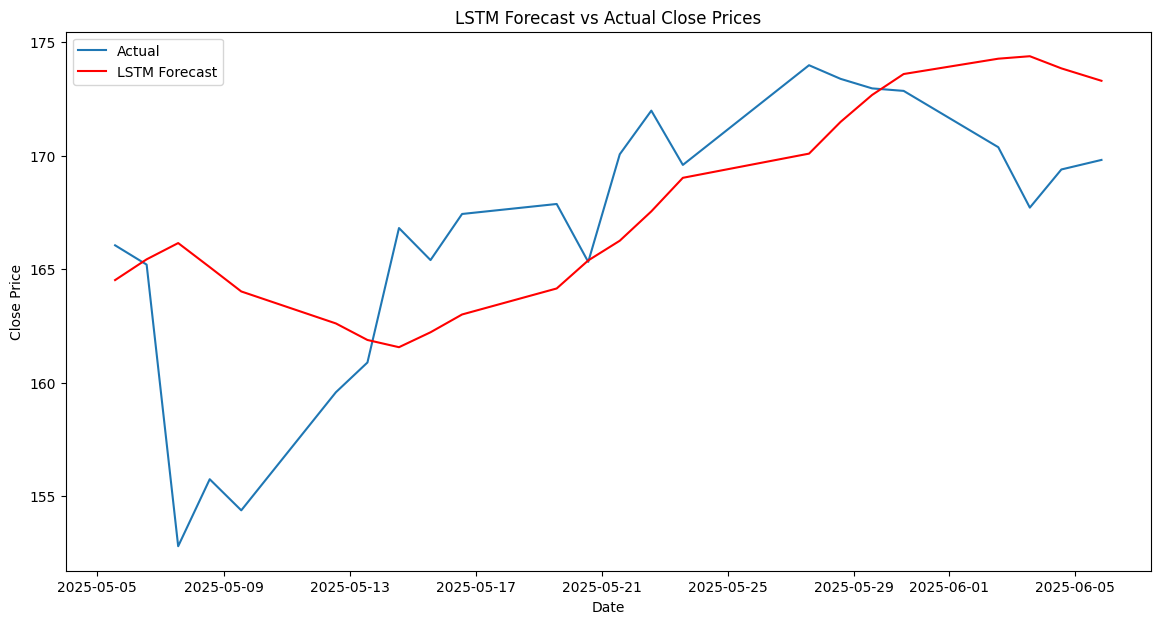

In [11]:
import pandas as pd
import numpy as np
from stockdex import Ticker
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def get_data(range, dataGranularity, stock):
    ticker = Ticker(stock)
    try:
        data = ticker.yahoo_api_price(range=range, dataGranularity=dataGranularity)
        df = pd.DataFrame({
            'timestamp': data['timestamp'],
            'close': data['close'],
        })
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)
        return df
    except Exception as e:
        print(f"An error occurred while fetching data for {stock}: {e}")
        return None

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# --- Load and scale data ---
data = get_data('1y', '1d', 'GOOG')
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['close']].values)

sequence_length = 20
X, y = create_sequences(scaled_data, sequence_length)

# --- Split train/test ---
train_size = int(len(X) * 0.9)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# --- Reshape for LSTM [samples, time steps, features] ---
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# --- Build LSTM Model ---
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)

# --- Predict on test data ---
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- Plot results ---
dates = data.index[sequence_length + train_size:sequence_length + train_size + len(predictions)]
plt.figure(figsize=(14, 7))
plt.plot(dates, y_test_actual, label='Actual')
plt.plot(dates, predictions, label='LSTM Forecast', color='red')
plt.title('LSTM Forecast vs Actual Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
